# Exercise 9.2: The Quantum Mechanical Finite Square Well

The goal of this problem is to calculate the eigenvalues of the quantum-mechanical finite square well, first examined in Exercise 1.2. This time we will use the "shooting method". 

The potential is given by: 

$$
V(x)=
\begin{cases}
-V_0& \quad \text{if $-a \leq x \leq a$;}\\ 
0& \quad \text{if $|x| > a$.}\\ 
\end{cases}
$$

and the time-independent Schrödinger equation for this potential is then given by: 

$\dfrac{-\hbar^2}{2m} \dfrac{ \mathrm{d}^2}{\mathrm{d}x^2} \psi(x) + V(x)\psi(x) = E\psi(x)$.

If we rescale the $x$ coordinate by a physical length $a$, we can rewrite this as: 

$\dfrac{-\hbar^2}{2ma^2} \dfrac{ \mathrm{d}^2}{\mathrm{d}x^2} \psi(x) + V(x)\psi(x) = E\psi(x)$.

We can then divide LHS and RHS by $V_0$: 

$\dfrac{-\hbar^2}{2ma^2 V_0} \dfrac{ \mathrm{d}^2}{\mathrm{d}x^2} \psi(x) + \dfrac{V(x)}{V_0} \psi(x)= \dfrac{E}{V_0}\psi(x)$,

to reach the form: 

$\left[-\dfrac{1}{z_0^2}  \dfrac{ \mathrm{d}^2}{\mathrm{d}x^2} + v(x) - \epsilon\right] \psi(x) = 0$,

where

$
z_0^2 = \dfrac{2 m a^2 V_0}{\hbar^2}\;,
$

which characterizes the "depth" of the well.

The rescaled potential is:
 
$$
v(x)=
\begin{cases}
-1& \quad \text{if $-1 \leq x \leq 1$;}\\ 
0& \quad \text{if $|x| > 1$.}\\ 
\end{cases}
$$

and the dimensionless energy is $\epsilon = E/V_0$. 

(a) Find all the eigenvalues for $z_0 = 1$ and $z_0 = 8$. For the $z_0=8$ case, switch to the Newton-Raphson method, using initial values close to the expected eigenvalue. 

(b) Plot the *normalized* $z_0=1$ wave function. There's only one, and it's even!

(c) Plot the *normalized* $z_0=8$ wave functions. 

Remember to enforce the wave function continuity condition at $x=-1$!

## Solution

In [4]:
import numpy as np
from functools import partial
import scipy as sp
import matplotlib.pyplot as plt

Define the relevant functions for the numerov solver.

In [5]:
def pot(x): # the finite square well potential
    if abs(x) < 1:
        return -1
    else:
        return 0

def source(x): # the source function in the Schrodinger equation for the finite square well potential
    return 0

def k2(z0,eps,x): # the function multplying the wavefunction in the Schrodinger equation for the finite square well potential
    return -z0**2*(pot(x)-eps)

# Numerov's algorithm (forward)
# takes as input the initial conditions y(0) and y'(0) as y0 and yp0
# h is the step size, the k-squared term (k2), the S term -- these are FUNCTIONS!
# the initial value of the independent variable x0, and the final value xf
# returns t,y as the solution arrays
def NumerovForw(k2, S, y0, yp0, h, x0, xf):
    """Returns the solution to a 2nd-order ODEs of the type: y'' + k^2 y = S(x) via the Numerov algorithm"""
    # the number of steps:
    N = int( (xf-x0)/h ) # needs to be an integer
    # get y1 via Taylor series:
    y1 = y0 + h * yp0
    # define the numpy arrays to return
    ya = np.zeros(N+1)
    xa = np.zeros(N+1)
    # set the first two values of the arrays:
    ya[0] = y0
    ya[1] = y1
    xa[0] = x0
    xa[1] = x0 + h
    # integrate via the Numerov algorithm:
    for n in range(1,N):
        x = x0 + n*h
        xa[n]=x
        h2dt = h**2/12 # appears often so let's just calculate it once!
        ya[n+1] = (2 * (1 - 5*h2dt * k2(x)) * ya[n] - (1 + h2dt *k2(x-h)) * ya[n-1] + h2dt*(S(x+h) + 10 * S(x) + S(x-h)))/((1 + h2dt * k2(x+h) ))    
    xa[N] = xf # set the last x value which is not set in the loop
    return xa,ya

# Numerov's algorithm (backward)
# takes as input the initial conditions y(0) and y'(0) as y0 and yp0
# h is the step size, the k-squared term (k2), the S term -- these are FUNCTIONS!
# the initial value of the independent variable x0, and the final value xf
# returns t,y as the solution arrays
def NumerovBack(k2, S, y0, yp0, h, x0, xf):
    """Returns the solution to a 2nd-order ODEs of the type: y'' + k^2 y = S(x) via the Numerov algorithm"""
    # the number of steps:
    N = int( (x0-xf)/h ) # needs to be an integer
    # get y1 via Taylor series:
    y1 = y0 - h * yp0
    # define the numpy arrays to return
    ya = np.zeros(N+1)
    xa = np.zeros(N+1)
    # set the first two values of the arrays:
    ya[0] = y0
    ya[1] = y1
    xa[0] = x0
    xa[1] = x0 - h
    # integrate via the Numerov algorithm:
    for n in range(1,N):
        x = x0 - n*h
        xa[n]=x
        h2dt = h**2/12 # appears often so let's just calculate it once!
        ya[n+1] = (2 * (1 - 5*h2dt * k2(x)) * ya[n] - (1 + h2dt *k2(x-h)) * ya[n-1] + h2dt*(S(x+h) + 10 * S(x) + S(x-h)))/((1 + h2dt * k2(x+h) ))    
    xa[N] = xf # set the last x value which is not set in the loop
    return xa,ya

def bisect(func,a,b,prec,N): # searches for a root of func on the interval [a,b] via the midpoint method, and returns the root within precision prec; runs through N iterations
    left = a # left end of interval for which the root is searched; initially a
    right = b # right end of interval for which the root is searched; initially b
    mid = (a+b)/2 # the midpoint of the interval for which the root is searched; initially set as the midpoint of [a,b]
    count = 0 # counts the number of iterations
    while abs(func(mid)) > prec and count < N:
        if np.sign(func(left)) != np.sign(func(mid)): # chooses a new interval to search according to where the function values change sign
            left = left
            right = mid
            mid = (left+right)/2
        else:
            left = mid
            right = right
            mid = (left+right)/2
        count = count + 1
    return mid

Now we feed the functions to Numerov at some large negative $x$, and propagate forward to the left endpoint of the well. We do this a second time, propagating from a large positive $x$ backwards to the left endpoint of the well. We then rescale the second array of values to ensure the function continuity.

In [6]:
h = 1E-2

def continues(array1,array2): # rescales the entries of array2 so that its last entry equals the last entry of array1
    return array1[-1]*array2/array2[-2]

def trialForw(z0,eps): # a guess of the eigenstate for the left-space
    return NumerovForw(partial(k2,z0,eps),source,1E-3,1E-3,h,-10,-1) # k2, S, y0, yp0, h, x0, xf
def trialBack(z0,eps): # a guess of the eigenstate for the right-space
    return [NumerovBack(partial(k2,z0,eps),source,1E-3,1E-3,h,10,-1-h)[0],continues(trialForw(z0,eps)[1],NumerovBack(partial(k2,z0,eps),source,1E-3,1E-3,h,10,-1-h)[1])]

Now we must ensure that the derivatives are continuous. We do this by searching for those values of $\epsilon$ that satisfy

$$\psi_<(x-h)-\psi_>(x-h)=0.$$

In [16]:
def f(z0,eps): # roots correspond to differentiable solutions
    return (trialForw(z0,eps)[1][-2]-trialBack(z0,eps)[1][-1])

Let us now find the eigenvalues corresponding to $z_0=1$.

In [59]:
z0List = [1,8] # list of z0 values

prec = 1E-10 # desired root precision
N = 10000 # maximum number of bisection runs
root = bisect(partial(f,z0List[0]),-1,0,prec,N)

In [60]:
print("The root is ", + round(root,3))

The root is  -0.452


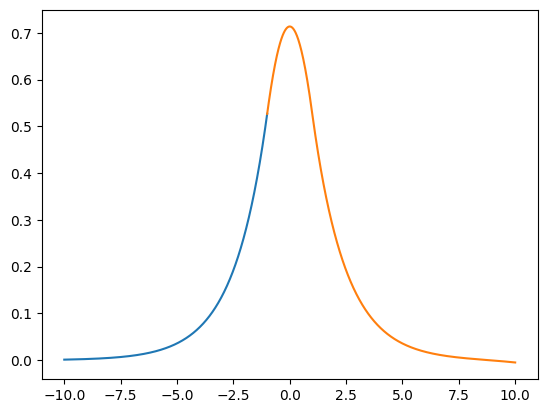

In [43]:
fig, ax = plt.subplots()

ax.plot(trialForw(1,root)[0],trialForw(1,root)[1])
ax.plot(trialBack(1,root)[0][0:-1],trialBack(1,root)[1][0:-1])

Now let us proceed to the case $z_0=8$. As suggested, we use the scipy Newton-Raphson root finder ```scipy.optimize.newton``` to find the eigenvalues. We start with a series of guesses for Newton-Rapson searching, and then fill a list with the resulant roots for each of the guesses.

The list of roots will likely have duplicates, as I used more guesses than the number of known roots just to be safe. Now, the ```set``` data type permits no duplicte elements. So to remedy these "extra" roots, I cast the root list to a set, and then cast back into a list. Of course, the "duplicate" roots that the optimizer spits out will not be precisely the same, so it was necessary to first round the roots to a sufficiently low number of digits past the decimal before casting to a set. 

In [64]:
guessList = [-1,-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1] # list of roots guesses for Newton-Raphson

rootList = [] # contains the roots
for g in guessList:
    r = sp.optimize.newton(partial(f,z0List[1]),g) # the root
    rootList.append(r) # adds the root to the list
rootList = list(set(np.round(rootList,5)))

print(rootList)

[-0.96933, -0.87776, -0.52003, -0.72684, -0.26582, -0.00708, 0.01696]


We see that the algorithm identified a root outside of our desired range of $[0,1]$, so we simply have to ignore this element.

In [74]:
for i in range(1,len(rootList)):
    print("Root", i, "is", rootList[i-1])

Root 1 is -0.96933
Root 2 is -0.87776
Root 3 is -0.52003
Root 4 is -0.72684
Root 5 is -0.26582
Root 6 is -0.00708


Now let us plot the bound states!

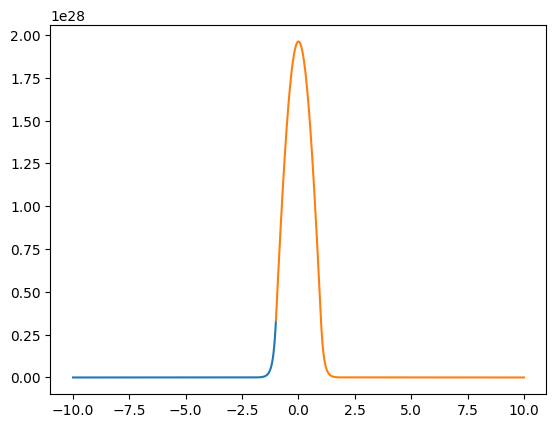

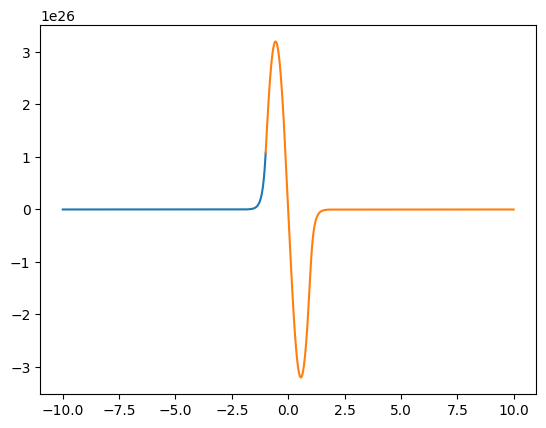

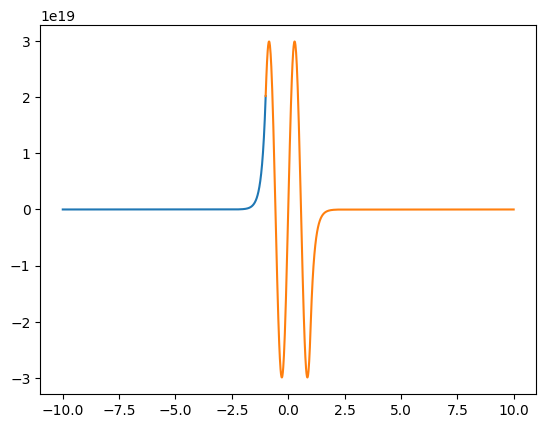

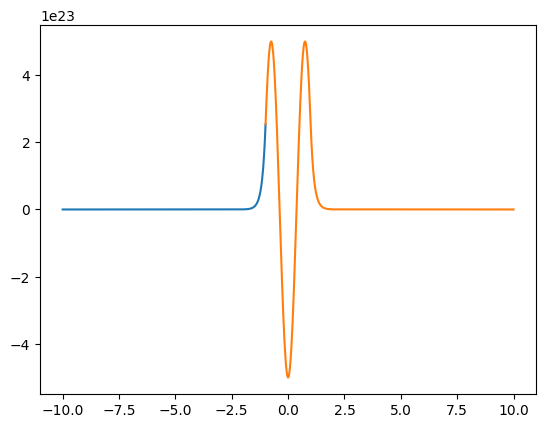

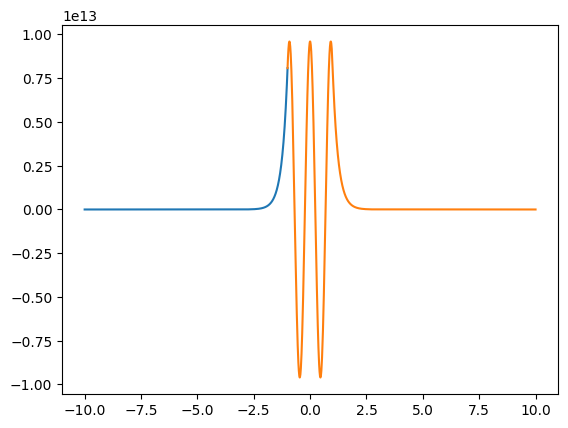

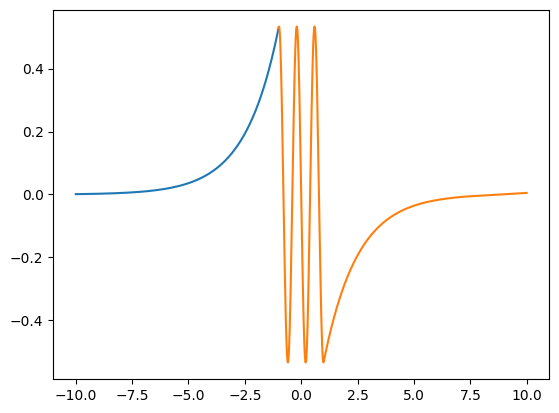

In [77]:
for r in rootList[0:-1]:
    fig, ax = plt.subplots()
    
    ax.plot(trialForw(z0List[1],r)[0],trialForw(z0List[1],r)[1])
    ax.plot(trialBack(z0List[1],r)[0][0:-1],trialBack(z0List[1],r)[1][0:-1])